# Import

In [1]:
import torch
import torch.nn as nn
torch.cuda.empty_cache()
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
import json
from tqdm import tqdm
from collections import Counter
import os


In [2]:
print(torch.__version__)

1.12.1


# Path

In [3]:
path_data_output='./data/ss_largeSizedDatasetRFAMonly/'

output_path_idx_train_valid_test_id_dict=path_data_output+'idx_train_valid_test_id_dict.json'
output_path_rna_data=path_data_output+'rna_data.csv'

output_path_temp_structure=path_data_output+'tempRNA.db'

# Read training, validation and test data info

In [4]:
idx_train_valid_test_id_dict = json.load(open(output_path_idx_train_valid_test_id_dict))
rna_data=pd.read_csv(output_path_rna_data,index_col=[0])

rna_training_set=rna_data[rna_data['id'].isin(idx_train_valid_test_id_dict['train'])]
rna_validation_set=rna_data[rna_data['id'].isin(idx_train_valid_test_id_dict['valid'])]
rna_testing_set=rna_data[rna_data['id'].isin(idx_train_valid_test_id_dict['test'])]

# Util

In [5]:
def compute_nm_seq(db_file_path,nmseq_outpath,param_nm):
    
    print('Compute nmotifs')
    os.system('./software/nmotifs'+' -i ' + db_file_path + ' -o '+ nmseq_outpath+' '+param_nm)
    
    print('Compute nmotifs seq rep')

    matnmSeq=pd.read_csv(nmseq_outpath+'matnmSeq.csv',index_col=[0])

    from sklearn.feature_extraction.text import CountVectorizer
    from tqdm import tqdm

    matnmSeq_columns=list(matnmSeq.columns)
    cutoff_percent_0=0.01

    for l in tqdm(range(len(matnmSeq_columns))):
        vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))
        kmer_ = vectorizer.fit_transform(matnmSeq[matnmSeq_columns[l]])
        new_column_list=matnmSeq_columns[l]+'__'+vectorizer.get_feature_names_out()

        if l==0:
            matnmSeq_nm=pd.DataFrame(kmer_.toarray(),columns=list(new_column_list), index=matnmSeq.index.values)
        else:
            matnmSeq_nm_temp=pd.DataFrame(kmer_.toarray(),columns=list(new_column_list), index=matnmSeq.index.values)
            matnmSeq_nm=pd.concat([matnmSeq_nm, matnmSeq_nm_temp], axis=1)

        #Remove column having more than cutoff percent of 0
        percent_0=(matnmSeq_nm == 0).astype(int).sum(axis=0)/matnmSeq_nm.shape[0]
        matnmSeq_nm.drop(list(percent_0[percent_0>cutoff_percent_0].index),axis=1)
    
    return matnmSeq_nm

# def compute_nm_seq(db_file_path,nmseq_outpath,param_nm):
    
#     print('Compute nmotifs')
#     os.system('./software/nmotifs'+' -i ' + db_file_path + ' -o '+ nmseq_outpath+' '+param_nm)
#     matnmSeq=pd.read_csv(nmseq_outpath+'matNmRep_SSbyNm.csv',index_col=[0])

#     return matnmSeq
    
def align_nm_seq_rep_to_a_ref(nmseq_to_align,nmseq_ref):
    nmseq_aligned_to_ref=pd.concat([nmseq_to_align,nmseq_ref], join='outer',axis=0) # Concat along y axis
    nmseq_aligned_to_ref=nmseq_aligned_to_ref[list(nmseq_ref.columns)] # keep only training set column
    nmseq_aligned_to_ref=nmseq_aligned_to_ref.fillna(0)#replace nan by zeros
    nmseq_aligned_to_ref=nmseq_aligned_to_ref.iloc[0:nmseq_to_align.shape[0]]#extract subopt vectors
    return(nmseq_aligned_to_ref)
    

# 1. Data Preprocessing

## 1.1 Training set prepocessing

### 1.1.1 Resample training data 

In [6]:
#upsampling training data
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
print('Original dataset shape %s' % Counter(rna_training_set['family']))
print('Total rna : ',len(rna_training_set['id']))

rs = RandomOverSampler(random_state=42)
#rs = RandomUnderSampler(random_state=42)

rna_training_set_resampled, family_rna_training_set_resampled = rs.fit_resample(rna_training_set, rna_training_set['family'])
print('Resampled dataset shape %s' % Counter(rna_training_set_resampled['family']))
print('Total rna after upsampling: ',len(rna_training_set_resampled['id']))

#Update id; some id_Seq are duplicated because of upsampling
rna_training_set_resampled['id']=range(rna_training_set_resampled.shape[0])
rna_training_set_resampled

Original dataset shape Counter({'glnA': 535, 'Downstream-peptide': 351, 'C4': 255, 'PhotoRC-II': 249, 'SAM-I-IV-variant': 245, 'SAM': 242, 'Cobalamin': 241, 'group-II-D1D4-3': 227, 'IMES-2': 205, 'PK-G12rRNA': 194, 'IsrR': 172, 'crcB': 161, 'HIV': 153, 'Cyano-1': 148, 'group-II-D1D4-7': 137, 'group-II-D1D4-1': 133, 'HCV': 123, 'IMES-1': 122, 'U2': 117, 'TwoAYGGAY': 117, 'Flavo-1': 113, 'Clostridiales-1': 109, 'U6': 106, 'manA': 106, 'pfl': 102, 'U5': 101, 'group-II-D1D4-6': 98, 'mir-1937': 96, 'U4': 95, 'Entero': 90, 'MOCO': 90, 'ykoK': 88, 'c-di-GMP-I': 86, '6S': 83, 'Prion': 83, 'FMN': 81, 'AdoCbl-variant': 81, 'group-II-D1D4-2': 81, 'group-II-D1D4-5': 78, 'potC': 76, 'Purine': 74, 'radC': 73, 'JUMPstart': 72, 'SAM-II': 70, 'mir-154': 68, 'msiK': 67, 'wcaG': 66, 'ar14': 66, 'sau-50': 66, 'Flavivirus': 62, 'HEARO': 62, 'TPP': 61, 'ydaO-yuaA': 59, 'Y': 58, 'U1': 56, 'MIR169': 56})
Total rna :  7006
Resampled dataset shape Counter({'U1': 535, 'U2': 535, '6S': 535, 'U4': 535, 'Y': 535, '

,id,id_seq,sequence,family,family_int,validated_structure,mfe_structure,centroid_structure,mea_structure,bd_distance_vs_mfe,bd_distance_vs_centroid,bd_distance_vs_mea
0,0,2_U1_RF00003_X14417,AUACUUACCUGGACGGGGUCAAUGGGUAAUCAAGAAGUUCCAUGGC...,U1,29,...........((((((((((.((((............))))))))...,...........((((((((((.((((............))))))))...,...........((((.((((..((((............)))).)))...,...........(((((((((.(((((............))))))))...,0.060000,0.081633,0.080000
1,1,4_U1_RF00003_X14419,AUACUUACCUGGACGGGGUCAAUGGGCGAUCAUGAACACCCAUGGC...,U1,29,...........((((((((((.((((.(........).))))))))...,...........((((((((((.((((.(........).))))))))...,...........(((((((((.(((((.(........).))))))))...,...........(((((((((.(((((.(........).))))))))...,0.043478,0.065217,0.065217
2,2,5_U1_RF00003_X14416,AUACUUACCUGGACGGGGUCUAUGGGCGAUCAUGUAGGUCCAUGGC...,U1,29,...............(((((.((((((..........)))))))))...,...((((((.....))((.((((((((..........)))))))))...,................((.((((((((..........)))))))))...,................((.((((((((..........)))))))))...,0.212766,0.156627,0.116279
3,3,7_U1_RF00003_X14414,AUACUUACCUGGACGGGGUCAAUAGGCGAUCAAUAAGACCCAUGGC...,U1,29,...........((((((((((...(((.........).))..))))...,..............((((((.....((((.((......((((((((...,..............((((((.....((((.(..................,..............((((((.....((((.((......((((((((...,0.528090,0.475000,0.528090
4,4,8_U1_RF00003_Z11883,AUACUUACCUGGACGGGGUUAAUGGGCGAUCAAUAAGACCCAUGGG...,U1,29,...........((((((.(((.(((((.........).)))))))....,...........(((((((((..(((....)))....)))))...((...,...........((((......(((((............))))).((...,...........((((......((((((.........).))))).((...,0.600000,0.488372,0.454545
...,...,...,...,...,...,...,...,...,...,...,...,...
29955,29955,6_ykoK_RF00380_AL035300,CAAGCACCUCGGUAGGUGAGGCUUCUGCAUGGAUAUAGGCCACCGA...,ykoK,55,...(((((((.......(((((..((((((((.((((((((((..(...,...(((((((((.((.(.((((..((((((((.((((((((((.((...,...(((((..((.((...((((..((((((((.....((((((.((...,...(((((((((.((...((((..((((((((.(((.((((((.((...,0.283019,0.297872,0.288462
29956,29956,130_ykoK_RF00380_ACIL02000005,GGUGCAAUUCGGUAGGUGAGACUACCAUAGGGAUACGGAUGACUAC...,ykoK,55,.........................(((((((....(((((((.((...,.((((..(..(((((......)))))..)..).)))...((((((....,..........(((((......))))).............((((((....,..........(((((......))))).............((((((....,0.625000,0.600000,0.600000
29957,29957,15_ykoK_RF00380_CP000717,CAAGCACCUCGCUAGGUGAGGCGUCUGCGCGGAUAUAGGCCACUGA...,ykoK,55,...(((((((.......((((((.((((((((.....((((((..(...,...(((((((.((((((..((((.((((((((.....(((((((((...,...(((((((.(...((..((((.((((((((.....(((((((((...,...(((((((.((((((..((((.((((((((.....(((((((((...,0.127273,0.102804,0.127273
29958,29958,156_ykoK_RF00380_CP002104,GAGCACGGUCGGUAGGUAAGGCUACCACGGGGAUACGGGUUGCUGC...,ykoK,55,....................(((..(.(((((....(((((((..(...,.......((((.(((((..((((..(.(((((....(((((((((....,.......((((..((((..((((....(((((....(((((((......,.......((((.(((((..((((..(.(((((....(((((((......,0.272727,0.228571,0.243243


### 1.2 Compute n-motif rep for training set

In [7]:
rna_training_set_validated_structure=rna_training_set_resampled.drop(['mfe_structure','centroid_structure','mea_structure'],axis=1)
rna_training_set_mfe_structure=rna_training_set_resampled.drop(['validated_structure','centroid_structure','mea_structure'],axis=1)
rna_training_set_centroid_structure=rna_training_set_resampled.drop(['validated_structure','mfe_structure','mea_structure'],axis=1)
rna_training_set_mea_structure=rna_training_set_resampled.drop(['validated_structure','mfe_structure','centroid_structure'],axis=1)

In [8]:
with open(output_path_temp_structure, 'w') as the_file:

    for i in tqdm(range(rna_training_set_validated_structure.shape[0])):
        
        # Valid structure
        the_file.write('>'+rna_training_set_validated_structure['id_seq'].iloc[i]+'\n')
        the_file.write(rna_training_set_validated_structure['sequence'].iloc[i]+'\n')
        the_file.write(rna_training_set_validated_structure['validated_structure'].iloc[i]+'\n')
    
matnmSeq_training_set_validated_structure=compute_nm_seq(output_path_temp_structure,path_data_output,'-n 0 -m 1')
matnmSeq_training_set_validated_structure

100%|██████████████████████████████████| 29960/29960 [00:00<00:00, 74930.93it/s]


Compute nmotifs

Running the super n-motifs program...

Extract n-motifs...
Took:0.942897 sec.
Filter and weight n-motifs to build the n-motifs representation ...
Took:1.17508 sec.

Compute and Write output matNmRep_SSbyNm.csv & matnmPos.csv files:
SS*n-motifs matrix that is the n-motif representation of SS (matNmRep_SSbyNm.csv) ...
n-motifsPosition matrix (matnmPos.csv) ...
n-motifsSequence matrix (matnmSeq.csv) ...
Execution of n-motifs program completed
Took:6.70352 sec.
Compute nmotifs seq rep


100%|█████████████████████████████████████████| 281/281 [02:45<00:00,  1.70it/s]


,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__au,B__c,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
2_U1_RF00003_X14417,4,1,3,0,0,1,0,2,2,3,...,0,0,0,0,0,0,0,0,0,0
4_U1_RF00003_X14419,3,0,3,0,0,1,0,1,2,3,...,0,0,0,0,0,0,0,0,0,0
5_U1_RF00003_X14416,4,2,0,2,1,0,0,3,2,0,...,0,0,0,0,0,0,0,0,0,0
7_U1_RF00003_X14414,2,1,3,0,0,0,1,2,0,3,...,0,0,0,0,0,0,0,0,0,0
8_U1_RF00003_Z11883,4,1,3,0,0,1,1,2,2,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6_ykoK_RF00380_AL035300,1,1,4,0,0,1,1,1,2,3,...,0,0,0,0,0,0,0,0,0,0
130_ykoK_RF00380_ACIL02000005,0,0,0,0,0,0,0,0,0,0,...,0,1,3,2,2,0,0,1,2,1
15_ykoK_RF00380_CP000717,0,1,3,0,0,2,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
156_ykoK_RF00380_CP002104,0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
with open(output_path_temp_structure, 'w') as the_file:

    for i in tqdm(range(rna_training_set_mfe_structure.shape[0])):
        
        # Valid structure
        the_file.write('>'+rna_training_set_mfe_structure['id_seq'].iloc[i]+'\n')
        the_file.write(rna_training_set_mfe_structure['sequence'].iloc[i]+'\n')
        the_file.write(rna_training_set_mfe_structure['mfe_structure'].iloc[i]+'\n')
    
matnmSeq_training_set_mfe_structure=compute_nm_seq(output_path_temp_structure,path_data_output,'-n 0 -m 1')
matnmSeq_training_set_mfe_structure

100%|██████████████████████████████████| 29960/29960 [00:00<00:00, 69320.57it/s]


Compute nmotifs

Running the super n-motifs program...

Extract n-motifs...
Took:0.973237 sec.
Filter and weight n-motifs to build the n-motifs representation ...
Took:1.15995 sec.

Compute and Write output matNmRep_SSbyNm.csv & matnmPos.csv files:
SS*n-motifs matrix that is the n-motif representation of SS (matNmRep_SSbyNm.csv) ...
n-motifsPosition matrix (matnmPos.csv) ...
n-motifsSequence matrix (matnmSeq.csv) ...
Execution of n-motifs program completed
Took:5.10697 sec.
Compute nmotifs seq rep


100%|█████████████████████████████████████████| 187/187 [01:24<00:00,  2.21it/s]


,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__ar,B__au,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
2_U1_RF00003_X14417,4,1,1,0,0,1,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
4_U1_RF00003_X14419,3,2,1,0,0,1,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
5_U1_RF00003_X14416,3,1,2,0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
7_U1_RF00003_X14414,1,1,2,0,0,0,0,2,0,0,...,0,0,1,2,2,1,2,1,1,1
8_U1_RF00003_Z11883,0,3,1,2,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6_ykoK_RF00380_AL035300,2,0,6,2,1,0,1,1,0,4,...,0,0,0,0,0,0,0,0,0,0
130_ykoK_RF00380_ACIL02000005,0,2,3,1,1,2,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
15_ykoK_RF00380_CP000717,0,2,4,2,2,0,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
156_ykoK_RF00380_CP002104,0,2,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
with open(output_path_temp_structure, 'w') as the_file:

    for i in tqdm(range(rna_training_set_centroid_structure.shape[0])):
        
        # Valid structure
        the_file.write('>'+rna_training_set_centroid_structure['id_seq'].iloc[i]+'\n')
        the_file.write(rna_training_set_centroid_structure['sequence'].iloc[i]+'\n')
        the_file.write(rna_training_set_centroid_structure['centroid_structure'].iloc[i]+'\n')
    
matnmSeq_training_set_centroid_structure=compute_nm_seq(output_path_temp_structure,path_data_output,'-n 0 -m 1')
matnmSeq_training_set_centroid_structure

100%|██████████████████████████████████| 29960/29960 [00:00<00:00, 68527.73it/s]


Compute nmotifs

Running the super n-motifs program...

Extract n-motifs...
Took:0.924322 sec.
Filter and weight n-motifs to build the n-motifs representation ...
Took:1.24471 sec.

Compute and Write output matNmRep_SSbyNm.csv & matnmPos.csv files:
SS*n-motifs matrix that is the n-motif representation of SS (matNmRep_SSbyNm.csv) ...
n-motifsPosition matrix (matnmPos.csv) ...
n-motifsSequence matrix (matnmSeq.csv) ...
Execution of n-motifs program completed
Took:8.1073 sec.
Compute nmotifs seq rep


100%|█████████████████████████████████████████| 376/376 [04:55<00:00,  1.27it/s]


,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__au,B__c,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
2_U1_RF00003_X14417,2,1,1,0,0,0,0,2,0,1,...,0,0,0,0,0,0,0,0,0,0
4_U1_RF00003_X14419,1,3,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5_U1_RF00003_X14416,1,1,2,0,0,0,0,1,1,2,...,0,0,0,0,0,0,0,0,0,0
7_U1_RF00003_X14414,1,0,1,0,0,0,0,1,0,1,...,0,0,1,2,2,1,2,1,1,1
8_U1_RF00003_Z11883,0,3,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6_ykoK_RF00380_AL035300,2,0,3,1,1,0,1,0,2,3,...,0,0,0,0,0,0,0,0,0,0
130_ykoK_RF00380_ACIL02000005,1,2,0,1,1,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15_ykoK_RF00380_CP000717,0,1,3,0,0,0,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
156_ykoK_RF00380_CP002104,0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
with open(output_path_temp_structure, 'w') as the_file:

    for i in tqdm(range(rna_training_set_mea_structure.shape[0])):
        
        # Valid structure
        the_file.write('>'+rna_training_set_mea_structure['id_seq'].iloc[i]+'\n')
        the_file.write(rna_training_set_mea_structure['sequence'].iloc[i]+'\n')
        the_file.write(rna_training_set_mea_structure['mea_structure'].iloc[i]+'\n')
    
matnmSeq_training_set_mea_structure=compute_nm_seq(output_path_temp_structure,path_data_output,'-n 0 -m 1')
matnmSeq_training_set_mea_structure

100%|██████████████████████████████████| 29960/29960 [00:00<00:00, 68033.39it/s]


Compute nmotifs

Running the super n-motifs program...

Extract n-motifs...
Took:1.00747 sec.
Filter and weight n-motifs to build the n-motifs representation ...
Took:1.23198 sec.

Compute and Write output matNmRep_SSbyNm.csv & matnmPos.csv files:
SS*n-motifs matrix that is the n-motif representation of SS (matNmRep_SSbyNm.csv) ...
n-motifsPosition matrix (matnmPos.csv) ...
n-motifsSequence matrix (matnmSeq.csv) ...
Execution of n-motifs program completed
Took:6.05728 sec.
Compute nmotifs seq rep


100%|█████████████████████████████████████████| 229/229 [01:57<00:00,  1.94it/s]


,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__au,B__c,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
2_U1_RF00003_X14417,2,2,1,1,1,1,0,2,0,1,...,0,0,0,0,0,0,0,0,0,0
4_U1_RF00003_X14419,1,3,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5_U1_RF00003_X14416,3,1,2,0,0,0,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0
7_U1_RF00003_X14414,1,1,2,0,0,0,0,2,0,2,...,0,0,1,2,2,1,2,1,1,1
8_U1_RF00003_Z11883,1,4,3,0,0,1,1,1,0,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6_ykoK_RF00380_AL035300,2,0,6,2,1,0,1,1,4,5,...,0,0,0,0,0,0,0,0,0,0
130_ykoK_RF00380_ACIL02000005,1,2,0,1,1,3,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15_ykoK_RF00380_CP000717,0,2,4,2,2,0,2,1,0,3,...,0,0,0,0,0,0,0,0,0,0
156_ykoK_RF00380_CP002104,0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# # align mfe, centroid and mea to valid structure features 
matnmSeq_training_set_mfe_structure=align_nm_seq_rep_to_a_ref(matnmSeq_training_set_mfe_structure,matnmSeq_training_set_validated_structure)
matnmSeq_training_set_centroid_structure=align_nm_seq_rep_to_a_ref(matnmSeq_training_set_centroid_structure,matnmSeq_training_set_validated_structure)
matnmSeq_training_set_mea_structure=align_nm_seq_rep_to_a_ref(matnmSeq_training_set_mea_structure,matnmSeq_training_set_validated_structure)

## 1.2 Validation set prepocessing

In [13]:
rna_validation_set_validated_structure=rna_validation_set.drop(['mfe_structure','centroid_structure','mea_structure'],axis=1)
rna_validation_set_mfe_structure=rna_validation_set.drop(['validated_structure','centroid_structure','mea_structure'],axis=1)

In [14]:
with open(output_path_temp_structure, 'w') as the_file:

    for i in tqdm(range(rna_validation_set_validated_structure.shape[0])):
        
        # Valid structure
        the_file.write('>'+rna_validation_set_validated_structure['id_seq'].iloc[i]+'\n')
        the_file.write(rna_validation_set_validated_structure['sequence'].iloc[i]+'\n')
        the_file.write(rna_validation_set_validated_structure['validated_structure'].iloc[i]+'\n')
    
matnmSeq_validation_set_validated_structure=compute_nm_seq(output_path_temp_structure,path_data_output,'-n 0 -m 1')
matnmSeq_validation_set_validated_structure

100%|████████████████████████████████████| 1752/1752 [00:00<00:00, 55496.64it/s]


Compute nmotifs

Running the super n-motifs program...

Extract n-motifs...
Took:0.056128 sec.
Filter and weight n-motifs to build the n-motifs representation ...
Took:0.070514 sec.

Compute and Write output matNmRep_SSbyNm.csv & matnmPos.csv files:
SS*n-motifs matrix that is the n-motif representation of SS (matNmRep_SSbyNm.csv) ...
n-motifsPosition matrix (matnmPos.csv) ...
n-motifsSequence matrix (matnmSeq.csv) ...
Execution of n-motifs program completed
Took:0.388167 sec.
Compute nmotifs seq rep


100%|█████████████████████████████████████████| 221/221 [00:05<00:00, 38.03it/s]


,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__au,B__c,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
1_U1_RF00003_X06810,4,1,1,0,0,1,0,2,2,1,...,0,0,0,0,0,0,0,0,0,0
45_U1_RF00003_V01266,0,2,2,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
51_U1_RF00003_X56629,2,3,2,1,1,1,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
55_U1_RF00003_X53544,4,1,4,1,1,1,2,0,2,3,...,0,0,0,0,0,0,0,0,0,0
57_U1_RF00003_X53541,4,2,4,2,1,1,2,0,2,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70_sau-50_RF02391_CP001022,0,0,2,0,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
72_sau-50_RF02391_ACWC01000004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82_sau-50_RF02391_ABQL01000005,2,0,1,1,1,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
96_sau-50_RF02391_AFHT01000091,1,1,4,0,0,0,2,0,1,4,...,0,0,0,0,0,0,0,0,0,0


In [15]:
with open(output_path_temp_structure, 'w') as the_file:

    for i in tqdm(range(rna_validation_set_mfe_structure.shape[0])):
        
        # MFE
        the_file.write('>'+rna_validation_set_mfe_structure['id_seq'].iloc[i]+'\n')
        the_file.write(rna_validation_set_mfe_structure['sequence'].iloc[i]+'\n')
        the_file.write(rna_validation_set_mfe_structure['mfe_structure'].iloc[i]+'\n')
        
matnmSeq_validation_set_mfe_structure=compute_nm_seq(output_path_temp_structure,path_data_output,'-n 0 -m 1')
matnmSeq_validation_set_mfe_structure

100%|████████████████████████████████████| 1752/1752 [00:00<00:00, 59234.23it/s]


Compute nmotifs

Running the super n-motifs program...

Extract n-motifs...
Took:0.056871 sec.
Filter and weight n-motifs to build the n-motifs representation ...
Took:0.069183 sec.

Compute and Write output matNmRep_SSbyNm.csv & matnmPos.csv files:
SS*n-motifs matrix that is the n-motif representation of SS (matNmRep_SSbyNm.csv) ...
n-motifsPosition matrix (matnmPos.csv) ...
n-motifsSequence matrix (matnmSeq.csv) ...
Execution of n-motifs program completed
Took:0.281167 sec.
Compute nmotifs seq rep


100%|█████████████████████████████████████████| 161/161 [00:02<00:00, 54.12it/s]


,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__au,B__c,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
1_U1_RF00003_X06810,3,1,1,1,1,1,0,1,2,1,...,0,1,1,2,1,1,1,1,1,2
45_U1_RF00003_V01266,1,1,2,2,2,2,0,0,1,2,...,1,2,0,2,2,0,1,1,1,3
51_U1_RF00003_X56629,2,2,1,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
55_U1_RF00003_X53544,3,2,4,1,1,1,1,0,2,3,...,0,1,3,3,1,1,0,0,2,2
57_U1_RF00003_X53541,3,3,4,2,1,1,1,0,2,3,...,0,1,3,3,1,1,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70_sau-50_RF02391_CP001022,1,0,7,4,2,1,2,0,0,7,...,0,0,0,0,0,0,0,0,0,0
72_sau-50_RF02391_ACWC01000004,3,6,1,2,2,3,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
82_sau-50_RF02391_ABQL01000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96_sau-50_RF02391_AFHT01000091,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# align 
matnmSeq_validation_set_validated_structure=align_nm_seq_rep_to_a_ref(matnmSeq_validation_set_validated_structure,matnmSeq_training_set_validated_structure)
matnmSeq_validation_set_mfe_structure=align_nm_seq_rep_to_a_ref(matnmSeq_validation_set_mfe_structure,matnmSeq_training_set_validated_structure)

In [17]:
matnmSeq_validation_set_validated_structure

,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__au,B__c,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
1_U1_RF00003_X06810,4,1,1,0,0,1,0,2,2,1,...,0,0,0,0,0,0,0,0,0,0
45_U1_RF00003_V01266,0,2,2,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
51_U1_RF00003_X56629,2,3,2,1,1,1,1,0,1,2,...,0,0,0,0,0,0,0,0,0,0
55_U1_RF00003_X53544,4,1,4,1,1,1,2,0,2,3,...,0,0,0,0,0,0,0,0,0,0
57_U1_RF00003_X53541,4,2,4,2,1,1,2,0,2,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70_sau-50_RF02391_CP001022,0,0,2,0,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
72_sau-50_RF02391_ACWC01000004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
82_sau-50_RF02391_ABQL01000005,2,0,1,1,1,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
96_sau-50_RF02391_AFHT01000091,1,1,4,0,0,0,2,0,1,4,...,0,0,0,0,0,0,0,0,0,0


In [18]:
matnmSeq_validation_set_mfe_structure

,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__au,B__c,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
1_U1_RF00003_X06810,3,1,1,1,1,1,0,1,2,1,...,0,1,1,2,1,1,1,1,1,2
45_U1_RF00003_V01266,1,1,2,2,2,2,0,0,1,2,...,1,2,0,2,2,0,1,1,1,3
51_U1_RF00003_X56629,2,2,1,1,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
55_U1_RF00003_X53544,3,2,4,1,1,1,1,0,2,3,...,0,1,3,3,1,1,0,0,2,2
57_U1_RF00003_X53541,3,3,4,2,1,1,1,0,2,3,...,0,1,3,3,1,1,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70_sau-50_RF02391_CP001022,1,0,7,4,2,1,2,0,0,7,...,0,0,0,0,0,0,0,0,0,0
72_sau-50_RF02391_ACWC01000004,3,6,1,2,2,3,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
82_sau-50_RF02391_ABQL01000005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96_sau-50_RF02391_AFHT01000091,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 1.3 Testing set prepocessing

In [19]:
rna_testing_set_validated_structure=rna_testing_set.drop(['mfe_structure','centroid_structure','mea_structure'],axis=1)
rna_testing_set_mfe_structure=rna_testing_set.drop(['validated_structure','centroid_structure','mea_structure'],axis=1)
rna_testing_set_centroid_structure=rna_testing_set.drop(['validated_structure','mfe_structure','mea_structure'],axis=1)
rna_testing_set_mea_structure=rna_testing_set.drop(['validated_structure','mfe_structure','centroid_structure'],axis=1)

In [20]:
with open(output_path_temp_structure, 'w') as the_file:

    for i in tqdm(range(rna_testing_set_validated_structure.shape[0])):
        
        # Valid structure
        the_file.write('>'+rna_testing_set_validated_structure['id_seq'].iloc[i]+'\n')
        the_file.write(rna_testing_set_validated_structure['sequence'].iloc[i]+'\n')
        the_file.write(rna_testing_set_validated_structure['validated_structure'].iloc[i]+'\n')
    
matnmSeq_testing_set_validated_structure=compute_nm_seq(output_path_temp_structure,path_data_output,'-n 0 -m 1')
matnmSeq_testing_set_validated_structure

100%|████████████████████████████████████| 3754/3754 [00:00<00:00, 68379.55it/s]


Compute nmotifs

Running the super n-motifs program...

Extract n-motifs...
Took:0.117182 sec.
Filter and weight n-motifs to build the n-motifs representation ...
Took:0.14716 sec.

Compute and Write output matNmRep_SSbyNm.csv & matnmPos.csv files:
SS*n-motifs matrix that is the n-motif representation of SS (matNmRep_SSbyNm.csv) ...
n-motifsPosition matrix (matnmPos.csv) ...
n-motifsSequence matrix (matnmSeq.csv) ...
Execution of n-motifs program completed
Took:0.766854 sec.
Compute nmotifs seq rep


100%|█████████████████████████████████████████| 250/250 [00:13<00:00, 18.99it/s]


,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__ar,B__au,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
3_U1_RF00003_Z11883,1,1,4,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6_U1_RF00003_X14415,0,1,4,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9_U1_RF00003_Z11883,4,1,5,0,0,1,1,2,0,2,...,0,0,0,0,0,0,0,0,0,0
12_U1_RF00003_Z11881,4,1,3,0,0,1,1,2,0,2,...,0,0,0,0,0,0,0,0,0,0
14_U1_RF00003_Z11881,1,1,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106_sau-50_RF02391_CP002780,2,1,2,1,0,1,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
113_sau-50_RF02391_ABCP01000020,2,4,3,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
115_sau-50_RF02391_CP002657,2,4,2,2,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
116_sau-50_RF02391_ADMF01000015,1,2,1,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
with open(output_path_temp_structure, 'w') as the_file:

    for i in tqdm(range(rna_testing_set_mfe_structure.shape[0])):
        
        # Valid structure
        the_file.write('>'+rna_testing_set_mfe_structure['id_seq'].iloc[i]+'\n')
        the_file.write(rna_testing_set_mfe_structure['sequence'].iloc[i]+'\n')
        the_file.write(rna_testing_set_mfe_structure['mfe_structure'].iloc[i]+'\n')
    
matnmSeq_testing_set_mfe_structure=compute_nm_seq(output_path_temp_structure,path_data_output,'-n 0 -m 1')
matnmSeq_testing_set_mfe_structure

100%|████████████████████████████████████| 3754/3754 [00:00<00:00, 68444.65it/s]


Compute nmotifs

Running the super n-motifs program...

Extract n-motifs...
Took:0.120288 sec.
Filter and weight n-motifs to build the n-motifs representation ...
Took:0.145799 sec.

Compute and Write output matNmRep_SSbyNm.csv & matnmPos.csv files:
SS*n-motifs matrix that is the n-motif representation of SS (matNmRep_SSbyNm.csv) ...
n-motifsPosition matrix (matnmPos.csv) ...
n-motifsSequence matrix (matnmSeq.csv) ...
Execution of n-motifs program completed
Took:0.641975 sec.
Compute nmotifs seq rep


100%|█████████████████████████████████████████| 182/182 [00:07<00:00, 25.04it/s]


,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__ar,B__au,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
3_U1_RF00003_Z11883,0,2,3,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6_U1_RF00003_X14415,2,3,4,1,1,2,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
9_U1_RF00003_Z11883,3,2,3,0,0,1,1,2,0,2,...,0,0,2,5,1,0,1,0,1,0
12_U1_RF00003_Z11881,3,2,3,0,0,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
14_U1_RF00003_Z11881,1,1,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106_sau-50_RF02391_CP002780,2,0,0,0,0,3,0,0,0,3,...,0,1,0,2,1,0,0,1,1,3
113_sau-50_RF02391_ABCP01000020,1,0,2,1,1,0,1,0,0,0,...,1,3,2,3,4,1,0,2,3,4
115_sau-50_RF02391_CP002657,3,3,1,1,1,1,1,2,0,1,...,1,1,2,1,1,0,0,1,1,1
116_sau-50_RF02391_ADMF01000015,0,1,2,3,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
with open(output_path_temp_structure, 'w') as the_file:

    for i in tqdm(range(rna_testing_set_centroid_structure.shape[0])):
        
        # Valid structure
        the_file.write('>'+rna_testing_set_centroid_structure['id_seq'].iloc[i]+'\n')
        the_file.write(rna_testing_set_centroid_structure['sequence'].iloc[i]+'\n')
        the_file.write(rna_testing_set_centroid_structure['centroid_structure'].iloc[i]+'\n')
    
matnmSeq_testing_set_centroid_structure=compute_nm_seq(output_path_temp_structure,path_data_output,'-n 0 -m 1')
matnmSeq_testing_set_centroid_structure

100%|████████████████████████████████████| 3754/3754 [00:00<00:00, 63609.37it/s]


Compute nmotifs

Running the super n-motifs program...

Extract n-motifs...
Took:0.114283 sec.
Filter and weight n-motifs to build the n-motifs representation ...
Took:0.151332 sec.

Compute and Write output matNmRep_SSbyNm.csv & matnmPos.csv files:
SS*n-motifs matrix that is the n-motif representation of SS (matNmRep_SSbyNm.csv) ...
n-motifsPosition matrix (matnmPos.csv) ...
n-motifsSequence matrix (matnmSeq.csv) ...
Execution of n-motifs program completed
Took:0.958893 sec.
Compute nmotifs seq rep


100%|█████████████████████████████████████████| 332/332 [00:24<00:00, 13.60it/s]


,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__au,B__c,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
3_U1_RF00003_Z11883,0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6_U1_RF00003_X14415,2,2,0,0,0,1,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
9_U1_RF00003_Z11883,1,3,1,1,1,1,0,2,0,1,...,0,0,2,5,1,0,1,0,1,0
12_U1_RF00003_Z11881,1,2,3,0,0,0,1,1,0,3,...,0,0,0,0,0,0,0,0,0,0
14_U1_RF00003_Z11881,0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106_sau-50_RF02391_CP002780,2,0,0,0,0,3,0,0,3,0,...,0,1,0,2,1,0,0,1,1,3
113_sau-50_RF02391_ABCP01000020,0,0,1,1,1,0,0,0,0,1,...,3,4,5,5,5,2,0,3,4,5
115_sau-50_RF02391_CP002657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116_sau-50_RF02391_ADMF01000015,0,1,2,1,1,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0


In [23]:
with open(output_path_temp_structure, 'w') as the_file:

    for i in tqdm(range(rna_testing_set_mea_structure.shape[0])):
        
        # Valid structure
        the_file.write('>'+rna_testing_set_mea_structure['id_seq'].iloc[i]+'\n')
        the_file.write(rna_testing_set_mea_structure['sequence'].iloc[i]+'\n')
        the_file.write(rna_testing_set_mea_structure['mea_structure'].iloc[i]+'\n')
    
matnmSeq_testing_set_mea_structure=compute_nm_seq(output_path_temp_structure,path_data_output,'-n 0 -m 1')
matnmSeq_testing_set_mea_structure

100%|████████████████████████████████████| 3754/3754 [00:00<00:00, 63435.61it/s]


Compute nmotifs

Running the super n-motifs program...

Extract n-motifs...
Took:0.119836 sec.
Filter and weight n-motifs to build the n-motifs representation ...
Took:0.14757 sec.

Compute and Write output matNmRep_SSbyNm.csv & matnmPos.csv files:
SS*n-motifs matrix that is the n-motif representation of SS (matNmRep_SSbyNm.csv) ...
n-motifsPosition matrix (matnmPos.csv) ...
n-motifsSequence matrix (matnmSeq.csv) ...
Execution of n-motifs program completed
Took:0.699261 sec.
Compute nmotifs seq rep


100%|█████████████████████████████████████████| 208/208 [00:09<00:00, 21.41it/s]


,B__ a,B__ c,B__ g,B__ u,B__a,B__aa,B__ac,B__ag,B__ar,B__au,...,S_9__g,S_9__ga,S_9__gc,S_9__gg,S_9__gu,S_9__u,S_9__ua,S_9__uc,S_9__ug,S_9__uu
3_U1_RF00003_Z11883,0,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6_U1_RF00003_X14415,5,2,3,0,0,3,1,0,0,4,...,0,0,0,0,0,0,0,0,0,0
9_U1_RF00003_Z11883,1,3,1,1,1,1,0,2,0,0,...,0,0,2,5,1,0,1,0,1,0
12_U1_RF00003_Z11881,3,2,3,0,0,1,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
14_U1_RF00003_Z11881,1,1,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106_sau-50_RF02391_CP002780,2,0,0,0,0,3,0,0,0,3,...,0,1,0,2,1,0,0,1,1,3
113_sau-50_RF02391_ABCP01000020,1,0,2,1,1,0,1,0,0,0,...,1,3,2,3,4,1,0,2,3,4
115_sau-50_RF02391_CP002657,2,1,2,1,0,1,1,1,0,1,...,1,1,0,2,1,1,0,2,1,2
116_sau-50_RF02391_ADMF01000015,0,1,2,3,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# align 
matnmSeq_testing_set_validated_structure=align_nm_seq_rep_to_a_ref(matnmSeq_testing_set_validated_structure,matnmSeq_training_set_validated_structure)
matnmSeq_testing_set_mfe_structure=align_nm_seq_rep_to_a_ref(matnmSeq_testing_set_mfe_structure,matnmSeq_training_set_validated_structure)
matnmSeq_testing_set_centroid_structure=align_nm_seq_rep_to_a_ref(matnmSeq_testing_set_centroid_structure,matnmSeq_training_set_validated_structure)
matnmSeq_testing_set_mea_structure=align_nm_seq_rep_to_a_ref(matnmSeq_testing_set_mea_structure,matnmSeq_training_set_validated_structure)

# 2. Training

In [25]:
print(matnmSeq_training_set_validated_structure.shape)
print(matnmSeq_training_set_mfe_structure.shape)
print(matnmSeq_training_set_centroid_structure.shape)
print(matnmSeq_training_set_mea_structure.shape)

print(matnmSeq_validation_set_validated_structure.shape)
print(matnmSeq_validation_set_mfe_structure.shape)

print(matnmSeq_testing_set_validated_structure.shape)
print(matnmSeq_testing_set_mfe_structure.shape)
print(matnmSeq_testing_set_centroid_structure.shape)
print(matnmSeq_testing_set_mea_structure.shape)


(29960, 6327)
(29960, 6327)
(29960, 6327)
(29960, 6327)
(1752, 6327)
(1752, 6327)
(3754, 6327)
(3754, 6327)
(3754, 6327)
(3754, 6327)


In [26]:
# Assuming you have your dataset loaded into pandas DataFrames: train_data, test_data

# Convert numpy arrays to PyTorch tensors
train_structure_validated_tensor = torch.tensor(matnmSeq_training_set_validated_structure.to_numpy(), dtype=torch.float32)
train_structure_mfe_tensor = torch.tensor(matnmSeq_training_set_mfe_structure.to_numpy(), dtype=torch.float32)
train_structure_centroid_tensor = torch.tensor(matnmSeq_training_set_centroid_structure.to_numpy(), dtype=torch.float32)
train_structure_mea_tensor = torch.tensor(matnmSeq_training_set_mea_structure.to_numpy(), dtype=torch.float32)

valid_structure_validated_tensor = torch.tensor(matnmSeq_validation_set_validated_structure.to_numpy(), dtype=torch.float32)
valid_structure_mfe_tensor = torch.tensor(matnmSeq_validation_set_mfe_structure.to_numpy(), dtype=torch.float32)

test_structure_validated_tensor = torch.tensor(matnmSeq_testing_set_validated_structure.to_numpy(), dtype=torch.float32)
test_structure_mfe_tensor = torch.tensor(matnmSeq_testing_set_mfe_structure.to_numpy(), dtype=torch.float32)
test_structure_centroid_tensor = torch.tensor(matnmSeq_testing_set_centroid_structure.to_numpy(), dtype=torch.float32)
test_structure_mea_tensor = torch.tensor(matnmSeq_testing_set_mea_structure.to_numpy(), dtype=torch.float32)

# Create DataLoader for batch processing
            
#batch_size = 1000
batch_size = 500
#batch_size = 164
#batch_size = 32

train_structure_loader = DataLoader(TensorDataset(train_structure_mfe_tensor, train_structure_validated_tensor), batch_size=batch_size, shuffle=True)
valid_structure_loader = DataLoader(TensorDataset(valid_structure_mfe_tensor, valid_structure_validated_tensor), batch_size=batch_size, shuffle=True)
test_structure_loader = DataLoader(TensorDataset(test_structure_mfe_tensor, test_structure_centroid_tensor, test_structure_mea_tensor, test_structure_validated_tensor), batch_size=batch_size, shuffle=False)

In [27]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [28]:
# Define the denoising autoencoder architecture
class DenoisingAutoencoder(nn.Module):
    
    def __init__(self, input_size):
        
        super(DenoisingAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(


            nn.Linear(input_size,3000 ),
            nn.Dropout(0.5),

            nn.BatchNorm1d(3000),
            nn.ReLU(),

       

            nn.Linear(3000,2000 ),
            #nn.Dropout(0.5),

            nn.BatchNorm1d(2000),
            nn.ReLU(),

            nn.Linear(2000, 1000),
                 #nn.ReLU(),


            )
        self.decoder = nn.Sequential(
      
            

            nn.Linear(1000, 2000),
                       # nn.Dropout(0.5),

            nn.BatchNorm1d(2000),
            nn.ReLU(),

             nn.Linear(2000, 3000),
                        #nn.Dropout(0.5),

            nn.BatchNorm1d(3000),
            nn.ReLU(),       

           nn.Linear( 3000,input_size),
           #nn.Dropout(0.5),
     
            #nn.ReLU(),
            #nn.ReLU(),
            #nn.ReLU(),
            #nn.ReLU(),

        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
input_size = len(matnmSeq_training_set_validated_structure.columns)  # Number of features
#hidden_size = 64
model = DenoisingAutoencoder(input_size).to(device)

print(model)

# Define loss function and optimizer
#criterion = nn.MSELoss()
#criterion = nn.L1Loss()
criterion=nn.CosineEmbeddingLoss()


#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay = 1e-6)
# optimizer = torch.optim.Adam(model.parameters(),
#                              lr = 0.1,
#                              weight_decay = 1e-8)
#optimizer = torch.optim.Adam(model.parameters(),
#                             lr = 0.1,weight_decay = 1e-8)

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=6327, out_features=3000, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): BatchNorm1d(3000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=3000, out_features=2000, bias=True)
    (5): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=2000, out_features=1000, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1000, out_features=2000, bias=True)
    (1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2000, out_features=3000, bias=True)
    (4): BatchNorm1d(3000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=3000, out_features=6327, bias=True)
  )
)


In [ ]:
# Training the model
num_epochs = 10000

list_avg_loss_train=[]
list_avg_loss_valid=[]

loss_train=[]
loss_train_mfe=[]
loss_valid=[]
loss_valid_mfe=[]

for epoch in range(num_epochs):
    
    #Train
    running_loss = []
    running_mfe_loss = []
    model.train()

    for data in train_structure_loader:

        inputs_structure_mfe_, inputs_structure_validated_ = data
        inputs_structure_mfe, inputs_structure_validated = inputs_structure_mfe_.to(device), inputs_structure_validated_.to(device)
        
        #inputs_structure_mfe_plus_inputs_structure_validated_=(inputs_structure_mfe_+inputs_structure_validated_).to(device)
        
        outputs = model(inputs_structure_mfe )
        
        #target=torch.ones(inputs_structure_mfe.shape[0])
        #loss = criterion(outputs,inputs_structure_validated  )
        #loss_mfe = criterion(inputs_structure_mfe,inputs_structure_validated  )
        
        target=torch.ones(inputs_structure_mfe.shape[0]).to(device)
        loss = criterion(outputs,inputs_structure_validated,target  )
        loss_mfe = criterion(inputs_structure_mfe,inputs_structure_validated,target  )
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss.append(loss.item())
        running_mfe_loss.append(loss_mfe.item())
       
    loss_train.append(np.mean(running_loss))
    loss_train_mfe.append(np.mean(running_mfe_loss))

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Train     Loss: {np.mean(running_loss)}")
    print(f"Train MFE Loss: {np.mean(running_mfe_loss)}")
    
#     loss_train.append(np.sum(running_loss))
#     loss_train_mfe.append(np.sum(running_mfe_loss))

#     print(f"Epoch [{epoch + 1}/{num_epochs}]")
#     print(f"Train     Loss: {np.sum(running_loss)}")
#     print(f"Train MFE Loss: {np.sum(running_mfe_loss)}")

    #Valid
    valid_loss = []
    mfe_loss= []
    model.eval()

    with torch.no_grad():
        
        for data in valid_structure_loader:
            
            inputs_valid_structure_mfe_, inputs_valid_structure_validated_ = data
            inputs_valid_structure_mfe, inputs_valid_structure_validated = inputs_valid_structure_mfe_.to(device), inputs_valid_structure_validated_.to(device)
        
            outputs_valid = model(inputs_valid_structure_mfe)
            #valid_loss.append(criterion(outputs_valid, inputs_valid_structure_validated).item())
            #mfe_loss.append( criterion(inputs_valid_structure_mfe, inputs_valid_structure_validated).item())
            
            target=torch.ones(inputs_valid_structure_mfe.shape[0]).to(device)
            valid_loss.append(criterion(outputs_valid, inputs_valid_structure_validated,target).item())
            mfe_loss.append( criterion(inputs_valid_structure_mfe, inputs_valid_structure_validated,target).item())
    
    loss_valid.append(np.mean(valid_loss))
    loss_valid_mfe.append(np.mean(mfe_loss))
    print(f"Valid       Loss: {np.mean(valid_loss)}")
    print(f"Valid Mfe   Loss: {np.mean(mfe_loss)}")
    
    # loss_valid.append(np.sum(valid_loss))
    # loss_valid_mfe.append(np.sum(mfe_loss))
    # print(f"Valid       Loss: {np.sum(valid_loss)}")
    # print(f"Valid Mfe   Loss: {np.sum(mfe_loss)}")

    list_avg_loss_valid.append(valid_loss)

Epoch [1/10000]
Train     Loss: 0.42404053459564844
Train MFE Loss: 0.1837794321278731
Valid       Loss: 0.33058924227952957
Valid Mfe   Loss: 0.1774209551513195
Epoch [2/10000]
Train     Loss: 0.3099625294407209
Train MFE Loss: 0.18378181830048562
Valid       Loss: 0.3052459582686424
Valid Mfe   Loss: 0.17355976998806
Epoch [3/10000]
Train     Loss: 0.28903246025244395
Train MFE Loss: 0.18377535566687583
Valid       Loss: 0.28811080753803253
Valid Mfe   Loss: 0.17761848121881485
Epoch [4/10000]
Train     Loss: 0.27256270945072175
Train MFE Loss: 0.1837649941444397
Valid       Loss: 0.27222849428653717
Valid Mfe   Loss: 0.1738111786544323
Epoch [5/10000]
Train     Loss: 0.2580334795018037
Train MFE Loss: 0.18377337058385212
Valid       Loss: 0.25852780416607857
Valid Mfe   Loss: 0.17386802285909653
Epoch [6/10000]
Train     Loss: 0.24498384967446327
Train MFE Loss: 0.1837880164384842
Valid       Loss: 0.24803828820586205
Valid Mfe   Loss: 0.17703747376799583
Epoch [7/10000]
Train     L


KeyboardInterrupt



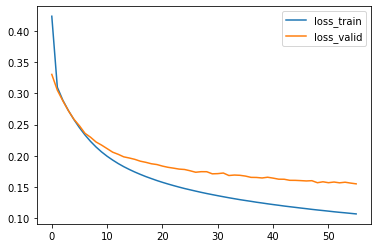

In [ ]:
#Visualize Loss
import pandas as pd

#df = pd.DataFrame({'loss_train':loss_train,'loss_train_mfe':loss_train_mfe,'loss_valid':loss_valid,'loss_valid_mfe':loss_valid_mfe})
df = pd.DataFrame({'loss_train':loss_train,'loss_valid':loss_valid})
#df = pd.DataFrame({'loss_train':loss_train,'loss_valid':loss_valid})
lines = df.plot.line()

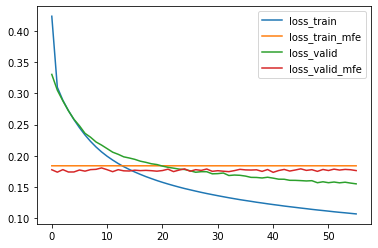

In [ ]:
df = pd.DataFrame({'loss_train':loss_train,'loss_train_mfe':loss_train_mfe,'loss_valid':loss_valid,'loss_valid_mfe':loss_valid_mfe})
#df = pd.DataFrame({'loss_train':loss_train,'loss_valid':loss_valid})
lines = df.plot.line()

# 2. Test representation

## 2.1. Reconstruction on Test set

In [ ]:
# Reconstruction on Test
model.eval()
test_loss_dmfe = []
test_loss_mfe= []
test_loss_dcentroid=[]
test_loss_centroid=[]
test_loss_dmea=[]
test_loss_mea=[]

with torch.no_grad():
    for data in test_structure_loader:
        inputs_structure_mfe_, inputs_structure_centroid_, inputs_structure_mea_, inputs_structure_validated_ = data
        inputs_structure_mfe, inputs_structure_centroid, inputs_structure_mea, inputs_structure_validated = inputs_structure_mfe_.to(device), inputs_structure_centroid_.to(device), inputs_structure_mea_.to(device), inputs_structure_validated_.to(device)

        outputs_dmfe = model(inputs_structure_mfe)
        outputs_dcentroid = model(inputs_structure_centroid)
        outputs_dmea = model(inputs_structure_mea)
        
        target=torch.ones(inputs_structure_mfe.shape[0]).to(device)
        
        test_loss_dmfe.append(criterion(outputs_dmfe, inputs_structure_validated,target).item())
        test_loss_mfe.append( criterion(inputs_structure_mfe, inputs_structure_validated,target).item())
        
        
        test_loss_dcentroid.append(criterion(outputs_dcentroid, inputs_structure_validated,target).item())
        test_loss_centroid.append(criterion(inputs_structure_centroid, inputs_structure_validated,target).item())
        
        test_loss_dmea.append( criterion(outputs_dmea, inputs_structure_validated,target).item())
        test_loss_mea.append( criterion(inputs_structure_mea, inputs_structure_validated,target).item())
        

print(f"Test Loss dmfe: {np.mean(test_loss_dmfe) }, {np.std(test_loss_dmfe) }")
print(f"Test Loss mfe: {np.mean(test_loss_mfe) }, {np.std(test_loss_mfe) }")
print(f"Test Loss dcentroid: {np.mean(test_loss_dcentroid) }, {np.std(test_loss_dcentroid) }")
print(f"Test Loss centroid: {np.mean(test_loss_centroid) }, {np.std(test_loss_centroid) }")
print(f"Test Loss dmea: {np.mean(test_loss_dmea) }, {np.std(test_loss_dmea) }")
print(f"Test Loss mea: {np.mean(test_loss_mea) }, {np.std(test_loss_mea) }")

Test Loss dmfe: 0.15076319593936205, 0.022864026227647338
Test Loss mfe: 0.1771278865635395, 0.04522195353418307
Test Loss dcentroid: 0.1755729392170906, 0.029516297534644315
Test Loss centroid: 0.2319770585745573, 0.05556033486231335
Test Loss dmea: 0.1599782994017005, 0.026585808429690373
Test Loss mea: 0.19405703619122505, 0.049375134868265065


## 2.2. Evaluation on Classification task - knn

In [33]:
# Test novel representation vs mfe via knn 1-2-3 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

list_of_method=[]
f1_score_macro=[]
recall_score_macro=[]
precision_score_macro=[]

# KNN
#nb_neighbors=1
nb_neighbors=3
#nb_neighbors=5
cl = KNeighborsClassifier(n_neighbors=nb_neighbors,metric='cosine')


In [34]:
# MFE rep
cl.fit(matnmSeq_training_set_mfe_structure, rna_training_set_validated_structure['family_int'])
mfe_rep_predict=(cl.predict(matnmSeq_testing_set_mfe_structure))

mfe_rep_f1_score_macro=f1_score(rna_testing_set_validated_structure['family_int'], mfe_rep_predict, average='macro')
mfe_rep_recall_score_macro=recall_score(rna_testing_set_validated_structure['family_int'], mfe_rep_predict, average='macro') 
mfe_rep_precision_score_macro=precision_score(rna_testing_set_validated_structure['family_int'], mfe_rep_predict, average='macro')

print(mfe_rep_f1_score_macro)
print(mfe_rep_recall_score_macro)
print(mfe_rep_precision_score_macro)
mfe_rep_results_f1_recall_precision=[mfe_rep_f1_score_macro,mfe_rep_recall_score_macro,mfe_rep_precision_score_macro]

0.8273064427816177
0.8199838377693528
0.8652809587109758


In [35]:
# DMFE rep
model.to('cpu')
train_structure_dmfe_vectors=model.encoder(train_structure_mfe_tensor).detach().numpy()
test_structure_dmfe_vectors=model.encoder(test_structure_mfe_tensor).detach().numpy()

cl.fit(train_structure_dmfe_vectors, rna_training_set_validated_structure['family_int'])
dmfe_rep_predict=(cl.predict(test_structure_dmfe_vectors))

dmfe_rep_f1_score_macro=f1_score(rna_testing_set_validated_structure['family_int'], dmfe_rep_predict, average='macro')
dmfe_rep_recall_score_macro=recall_score(rna_testing_set_validated_structure['family_int'], dmfe_rep_predict, average='macro') 
dmfe_rep_precision_score_macro=precision_score(rna_testing_set_validated_structure['family_int'], dmfe_rep_predict, average='macro')

print(dmfe_rep_f1_score_macro)
print(dmfe_rep_recall_score_macro)
print(dmfe_rep_precision_score_macro)
dmfe_rep_results_f1_recall_precision=[dmfe_rep_f1_score_macro,dmfe_rep_recall_score_macro,dmfe_rep_precision_score_macro]

0.921988271313922
0.9203105954314069
0.9298904247514644


In [36]:
# Centroid rep
cl.fit(matnmSeq_training_set_centroid_structure, rna_training_set_validated_structure['family_int'])
centroid_rep_predict=(cl.predict(matnmSeq_testing_set_centroid_structure))

centroid_rep_f1_score_macro=f1_score(rna_testing_set_validated_structure['family_int'], centroid_rep_predict, average='macro')
centroid_rep_recall_score_macro=recall_score(rna_testing_set_validated_structure['family_int'], centroid_rep_predict, average='macro') 
centroid_rep_precision_score_macro=precision_score(rna_testing_set_validated_structure['family_int'], centroid_rep_predict, average='macro')

print(centroid_rep_f1_score_macro)
print(centroid_rep_recall_score_macro)
print(centroid_rep_precision_score_macro)
centroid_rep_results_f1_recall_precision=[centroid_rep_f1_score_macro,centroid_rep_recall_score_macro,centroid_rep_precision_score_macro]

0.8084273157771843
0.8064689271651215
0.8339529578956871


In [37]:
# DCentroid rep
model.to('cpu')
train_structure_dcentroid_vectors=model.encoder(train_structure_centroid_tensor).detach().numpy()
test_structure_dcentroid_vectors=model.encoder(test_structure_centroid_tensor).detach().numpy()

cl.fit(train_structure_dcentroid_vectors, rna_training_set_validated_structure['family_int'])
dcentroid_rep_predict=(cl.predict(test_structure_dcentroid_vectors))

dcentroid_rep_f1_score_macro=f1_score(rna_testing_set_validated_structure['family_int'], dcentroid_rep_predict, average='macro')
dcentroid_rep_recall_score_macro=recall_score(rna_testing_set_validated_structure['family_int'], dcentroid_rep_predict, average='macro') 
dcentroid_rep_precision_score_macro=precision_score(rna_testing_set_validated_structure['family_int'], dcentroid_rep_predict, average='macro')

print(dcentroid_rep_f1_score_macro)
print(dcentroid_rep_recall_score_macro)
print(dcentroid_rep_precision_score_macro)
dcentroid_rep_results_f1_recall_precision=[dcentroid_rep_f1_score_macro,dcentroid_rep_recall_score_macro,dcentroid_rep_precision_score_macro]

0.9000307412524372
0.9017353165434964
0.9051871053724012


In [38]:
# MEA rep
cl.fit(matnmSeq_training_set_mea_structure, rna_training_set_validated_structure['family_int'])
mea_rep_predict=(cl.predict(matnmSeq_testing_set_mea_structure))

mea_rep_f1_score_macro=f1_score(rna_testing_set_validated_structure['family_int'], mea_rep_predict, average='macro')
mea_rep_recall_score_macro=recall_score(rna_testing_set_validated_structure['family_int'], mea_rep_predict, average='macro') 
mea_rep_precision_score_macro=precision_score(rna_testing_set_validated_structure['family_int'], mea_rep_predict, average='macro')

print(mea_rep_f1_score_macro)
print(mea_rep_f1_score_macro)
print(mea_rep_precision_score_macro)
mea_rep_results_f1_recall_precision=[mea_rep_f1_score_macro,mea_rep_f1_score_macro,mea_rep_precision_score_macro]

0.820947759411352
0.820947759411352
0.8512196281253079


In [39]:
# DMEA rep
model.to('cpu')
train_structure_dmea_vectors=model.encoder(train_structure_mea_tensor).detach().numpy()
test_structure_dmea_vectors=model.encoder(test_structure_mea_tensor).detach().numpy()

cl.fit(train_structure_dmea_vectors, rna_training_set_validated_structure['family_int'])
dmea_rep_predict=(cl.predict(test_structure_dmea_vectors))

dmea_rep_f1_score_macro=f1_score(rna_testing_set_validated_structure['family_int'], dmea_rep_predict, average='macro')
dmea_rep_recall_score_macro=recall_score(rna_testing_set_validated_structure['family_int'], dmea_rep_predict, average='macro') 
dmea_rep_precision_score_macro=precision_score(rna_testing_set_validated_structure['family_int'], dmea_rep_predict, average='macro')

print(dmea_rep_f1_score_macro)
print(dmea_rep_recall_score_macro)
print(dmea_rep_precision_score_macro)
dmea_rep_results_f1_recall_precision=[dmea_rep_f1_score_macro,dmea_rep_recall_score_macro,dmea_rep_precision_score_macro]

0.9200682835168467
0.9214637915984655
0.9236596252539913


In [40]:
# Validated rep
cl.fit(matnmSeq_training_set_validated_structure, rna_training_set_validated_structure['family_int'])
validated_str_rep_predict=(cl.predict(matnmSeq_testing_set_validated_structure))

validated_str_rep_f1_score_macro=f1_score(rna_testing_set_validated_structure['family_int'], validated_str_rep_predict, average='macro')
validated_str_rep_recall_score_macro=recall_score(rna_testing_set_validated_structure['family_int'], validated_str_rep_predict, average='macro') 
validated_str_rep_precision_score_macro=precision_score(rna_testing_set_validated_structure['family_int'], validated_str_rep_predict, average='macro')

print(validated_str_rep_f1_score_macro)
print(validated_str_rep_recall_score_macro)
print(validated_str_rep_precision_score_macro)
validated_str_rep_results_f1_recall_precision=[validated_str_rep_f1_score_macro,validated_str_rep_recall_score_macro,validated_str_rep_precision_score_macro]

0.9410623270097096
0.9398150552255389
0.9493346040988045


In [41]:
results_denoising_mfe_class_task=pd.DataFrame([mfe_rep_results_f1_recall_precision,dmfe_rep_results_f1_recall_precision,validated_str_rep_results_f1_recall_precision])
results_denoising_mfe_class_task.index=['mfe','dmfe','validated_structure']
results_denoising_mfe_class_task.columns=['f1','recall','precision']
results_denoising_mfe_class_task

,f1,recall,precision
mfe,0.827306,0.819984,0.865281
dmfe,0.921988,0.920311,0.929890
validated_structure,0.941062,0.939815,0.949335


In [42]:
results_transfer_denoising_class_task=pd.DataFrame([mfe_rep_results_f1_recall_precision,centroid_rep_results_f1_recall_precision ,mea_rep_results_f1_recall_precision,
                                                    dmfe_rep_results_f1_recall_precision,dcentroid_rep_results_f1_recall_precision,dmea_rep_results_f1_recall_precision
                                                     ])
results_transfer_denoising_class_task.index=['mfe','centroid','mea','dmfe','dcentroid','dmea']
results_transfer_denoising_class_task.columns=['f1','recall','precision']
results_transfer_denoising_class_task

,f1,recall,precision
mfe,0.827306,0.819984,0.865281
centroid,0.808427,0.806469,0.833953
mea,0.820948,0.820948,0.851220
dmfe,0.921988,0.920311,0.929890
dcentroid,0.900031,0.901735,0.905187
dmea,0.920068,0.921464,0.923660


In [84]:
# detailed report
from sklearn.metrics import classification_report

#MFE
detailed_report_mfe=pd.DataFrame(classification_report(rna_testing_set_validated_structure['family_int'], mfe_rep_predict,output_dict=True))
#DMFE
detailed_report_dmfe=pd.DataFrame(classification_report(rna_testing_set_validated_structure['family_int'], dmfe_rep_predict,output_dict=True))
#Centroid
detailed_report_centroid=pd.DataFrame(classification_report(rna_testing_set_validated_structure['family_int'], centroid_rep_predict,output_dict=True))
#DCentroid
detailed_report_dcentroid=pd.DataFrame(classification_report(rna_testing_set_validated_structure['family_int'], dcentroid_rep_predict,output_dict=True))
#MEA
detailed_report_mea=pd.DataFrame(classification_report(rna_testing_set_validated_structure['family_int'], mea_rep_predict,output_dict=True))
#DMEA
detailed_report_dmea=pd.DataFrame(classification_report(rna_testing_set_validated_structure['family_int'], dmea_rep_predict,output_dict=True))
#Validated structure
detailed_report_validated_structure=pd.DataFrame(classification_report(rna_testing_set_validated_structure['family_int'], validated_str_rep_predict,output_dict=True))

## 2.3. Visualize representation with tsne

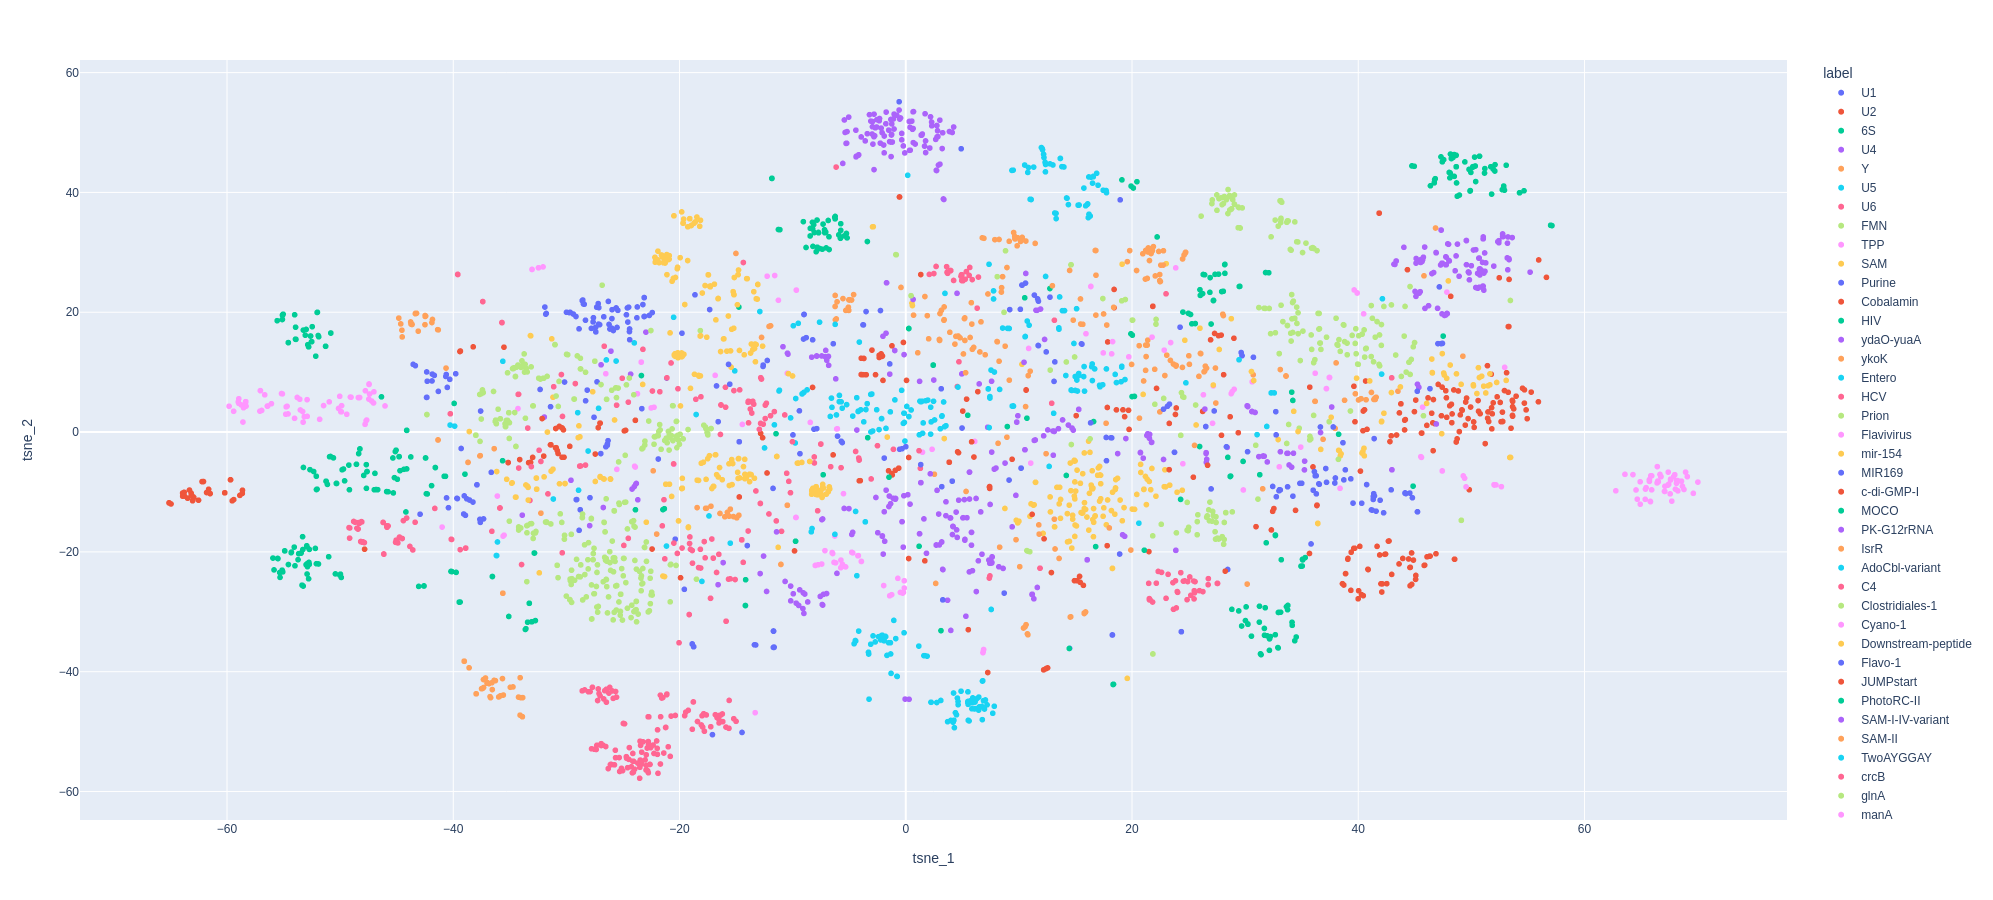

In [69]:
# Visualize MFE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=50).fit_transform(matnmSeq_testing_set_mfe_structure)

tsne_result_df = pd.DataFrame({'tsne_1': X_embedded[:,0],
                               'tsne_2': X_embedded[:,1],
                               'label': rna_testing_set_validated_structure['family']})
import plotly.express as px
fig = px.scatter(tsne_result_df, x="tsne_1", y="tsne_2", color="label",width=900, height=900)
fig.show()

In [1]:
# Visualize DMFE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=50).fit_transform(test_structure_dmfe_vectors)

tsne_result_df = pd.DataFrame({'tsne_1': X_embedded[:,0],
                               'tsne_2': X_embedded[:,1],
                               'label': rna_testing_set_validated_structure['family']})
import plotly.express as px
fig = px.scatter(tsne_result_df, x="tsne_1", y="tsne_2", color="label",width=900, height=900)
fig.show()

NameError: name 'test_structure_dmfe_vectors' is not defined